In [1]:
from modules.utils_data import load_data
from modules.plotting import plot_scatter_and_line
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors

In [2]:
%%capture
# The previous line silences the output because I don't like it

# Load the data
df_combined = load_data()

In [3]:
# Split the train/test data
train, test = train_test_split(df_combined, test_size=0.3, random_state=42)
for col in df_combined.columns[1:]:
    print(f'{col}: {test[col].count()/df_combined[col].count()}')

LogVP: 0.3108348134991119
LogP: 0.303577830357783
LogOH: 0.3352601156069364
LogBCF: 0.27884615384615385
LogHalfLife: 0.37333333333333335
BP: 0.3094054849990797
Clint: 0.2783882783882784
FU: 0.29283489096573206
LogHL: 0.3199426111908178
LogKmHL: 0.28835489833641403
LogKOA: 0.32222222222222224
LogKOC: 0.32088520055325037
MP: 0.30270770654940987
LogMolar: 0.29888803680981596


In [4]:
num_clusters=97

In [5]:
def CompDesc(smiles):
    mols = [Chem.MolFromSmiles(smi) for smi in smiles]
    mols = [Chem.AddHs(mol) for mol in mols]

    data = {'SMILES': smiles}
    desc = pd.DataFrame(data)

    descriptors = ['MolWt', 'HeavyAtomCount', 'RingCount', 'NumHDonors', 'NumHAcceptors', 'NumRotatableBonds', 
                   'NumAromaticRings', 'NumSaturatedRings', 'NumAliphaticRings', 'NumHeteroatoms', 
                   'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumSaturatedCarbocycles', 
                   'NumSaturatedHeterocycles', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles']

    for descriptor in descriptors:
        desc[descriptor] = desc['SMILES'].apply(lambda x: getattr(Descriptors, descriptor)(Chem.MolFromSmiles(x)))

    return desc

In [6]:
def getMoldescriptors(mol, missingVal=None):
    ''' calculate the full list of descriptors for a molecule
    
        missingVal is used if the descriptor cannot be calculated
    '''
    res = {}
    for nm,fn in Descriptors._descList:
        try:
            val = fn(mol)
        except:
            import traceback
            traceback.print_exc()
            val = missingVal
        res[nm] = val
    return res

## Preparation of the data and caluclation of the molecular descriptors

In [7]:

data = train.dropna(subset='LogP')
print('Train rows: ', len(train))
print('Test rows: ', len(test))
print('Total rows: ', len(data))

smiles = data['SMILES']

data.head()

Train rows:  16259
Test rows:  6969
Total rows:  9713


,SMILES,LogVP,LogP,LogOH,LogBCF,LogHalfLife,BP,Clint,FU,LogHL,LogKmHL,LogKOA,LogKOC,MP,LogMolar
8342,CCCc1cccc(OCC(=O)O)c1,NaN,2.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17224,N#CCN(CC#N)N=O,NaN,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12745,COc1cc(OC)cc(C2C(=O)c3ccccc3C2=O)c1,NaN,2.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6006,CCC1OC(=O)C(C)C(OC2CC(C)(OC)C(OC(C)=O)C(C)O2)C...,NaN,3.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11456,CNc1cccc2ccccc12,NaN,2.88,NaN,NaN,NaN,294.5,NaN,NaN,NaN,NaN,NaN,NaN,174.0,NaN


In [8]:
data = data.fillna(0.0)

In [9]:
data

,SMILES,LogVP,LogP,LogOH,LogBCF,LogHalfLife,BP,Clint,FU,LogHL,LogKmHL,LogKOA,LogKOC,MP,LogMolar
8342,CCCc1cccc(OCC(=O)O)c1,0.0,2.71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000
17224,N#CCN(CC#N)N=O,0.0,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000
12745,COc1cc(OC)cc(C2C(=O)c3ccccc3C2=O)c1,0.0,2.86,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000
6006,CCC1OC(=O)C(C)C(OC2CC(C)(OC)C(OC(C)=O)C(C)O2)C...,0.0,3.23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000
11456,CNc1cccc2ccccc12,0.0,2.88,0.0,0.0,0.0,294.5,0.0,0.0,0.0,0.0,0.0,0.00,174.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,CNC(=O)c1ccccc1,0.0,0.86,0.0,0.0,0.0,291.0,0.0,0.0,0.0,0.0,0.0,1.68,82.0,-0.920819
11964,COC(=O)c1nc(NCC(O)CO)cnc1[N+](=O)[O-],0.0,-0.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000
21575,O=[N+]([O-])c1ccc2c(c1)Cc1cc([N+](=O)[O-])ccc1-2,0.0,3.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,334.0,0.000000
5390,CCC(C(=O)OCc1ccccc1C)C(CO)Cc1cncn1C,0.0,2.42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000


In [10]:
desc = CompDesc(smiles)
desc.head()

,SMILES,MolWt,HeavyAtomCount,RingCount,NumHDonors,NumHAcceptors,NumRotatableBonds,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,NumHeteroatoms,NumAromaticCarbocycles,NumAromaticHeterocycles,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumAliphaticCarbocycles,NumAliphaticHeterocycles
8342,CCCc1cccc(OCC(=O)O)c1,194.230,14,1,1,2,5,1,0,0,3,1,0,0,0,0,0
17224,N#CCN(CC#N)N=O,124.103,9,0,0,4,3,0,0,0,5,0,0,0,0,0,0
12745,COc1cc(OC)cc(C2C(=O)c3ccccc3C2=O)c1,282.295,21,3,0,4,3,2,0,1,4,2,0,0,0,1,0
6006,CCC1OC(=O)C(C)C(OC2CC(C)(OC)C(OC(C)=O)C(C)O2)C...,759.975,53,3,3,14,8,0,3,3,14,0,0,0,3,0,3
11456,CNc1cccc2ccccc12,157.216,12,2,1,1,1,2,0,0,1,2,0,0,0,0,0


In [11]:
len(desc)

9713

## Principal Component Analysis 

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

descriptors = desc.drop('SMILES', axis=1)

scaler = StandardScaler()
standardized_descriptors = scaler.fit_transform(descriptors)

num_components = 10
pca = PCA(n_components=num_components)

principal_components = pca.fit_transform(standardized_descriptors)

explained_variance = 0

for i in range(num_components):
    desc[f'PC{i+1}'] = principal_components[:, i]
    explained_variance += pca.explained_variance_ratio_[i]
    if explained_variance >= 0.7 and explained_variance < 0.8:
        print(f'70% of the total variance is explained by the first {i+1} principal components')
    elif explained_variance >= 0.8:
        print(f'80% of the total variance is explained by the first {i+1} principal components')
        break

desc.head()

70% of the total variance is explained by the first 4 principal components
80% of the total variance is explained by the first 5 principal components


,SMILES,MolWt,HeavyAtomCount,RingCount,NumHDonors,NumHAcceptors,NumRotatableBonds,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,...,NumAromaticHeterocycles,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumAliphaticCarbocycles,NumAliphaticHeterocycles,PC1,PC2,PC3,PC4,PC5
8342,CCCc1cccc(OCC(=O)O)c1,194.230,14,1,1,2,5,1,0,0,...,0,0,0,0,0,-1.473430,0.177413,-0.236315,-0.477425,-0.790010
17224,N#CCN(CC#N)N=O,124.103,9,0,0,4,3,0,0,0,...,0,0,0,0,0,-2.063461,1.355956,-1.759608,-0.005732,0.106699
12745,COc1cc(OC)cc(C2C(=O)c3ccccc3C2=O)c1,282.295,21,3,0,4,3,2,0,1,...,0,0,0,1,0,0.520243,-0.538536,2.063174,-0.806500,-0.688933
6006,CCC1OC(=O)C(C)C(OC2CC(C)(OC)C(OC(C)=O)C(C)O2)C...,759.975,53,3,3,14,8,0,3,3,...,0,0,3,0,3,10.657098,-1.096052,-4.036136,3.677311,-1.812456
11456,CNc1cccc2ccccc12,157.216,12,2,1,1,1,2,0,0,...,0,0,0,0,0,-1.890172,-0.045513,2.038449,-0.017808,-0.929928


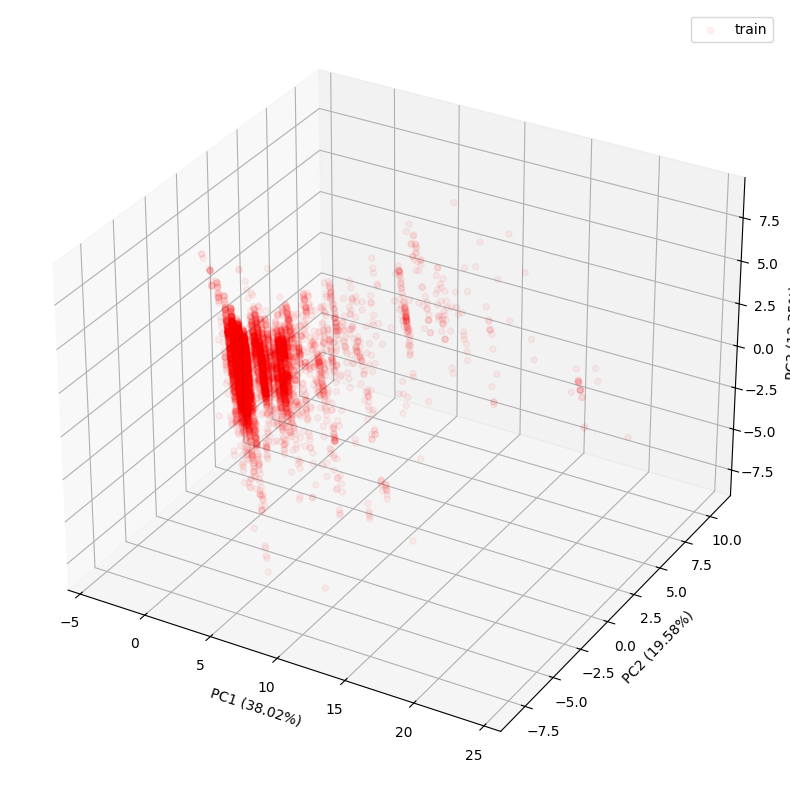

In [13]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(desc['PC1'], desc['PC2'], desc['PC3'], c='r', marker='o', alpha=0.05, label='train')
#ax.scatter(desc['PC1'][:18581], desc['PC2'][:18581], desc['PC3'][:18581], c='r', marker='o', alpha=0.05, label='train')
#ax.scatter(desc['PC1'][18582:-12], desc['PC2'][18582:-12], desc['PC3'][18582:-12], c='b', marker='o', alpha=0.01,label='test')
#ax.scatter(desc['PC1'][-12:], desc['PC2'][-12:], desc['PC3'][-12:], c='g', s=90, alpha=1,label='SAMPL6')
ax.set_xlabel(f'PC1 ({round(pca.explained_variance_ratio_[0]*100, 2)}%)')
ax.set_ylabel(f'PC2 ({round(pca.explained_variance_ratio_[1]*100, 2)}%)')
ax.set_zlabel(f'PC3 ({round(pca.explained_variance_ratio_[2]*100, 2)}%)')
plt.tight_layout()
plt.legend()
plt.show()

## Clustering 

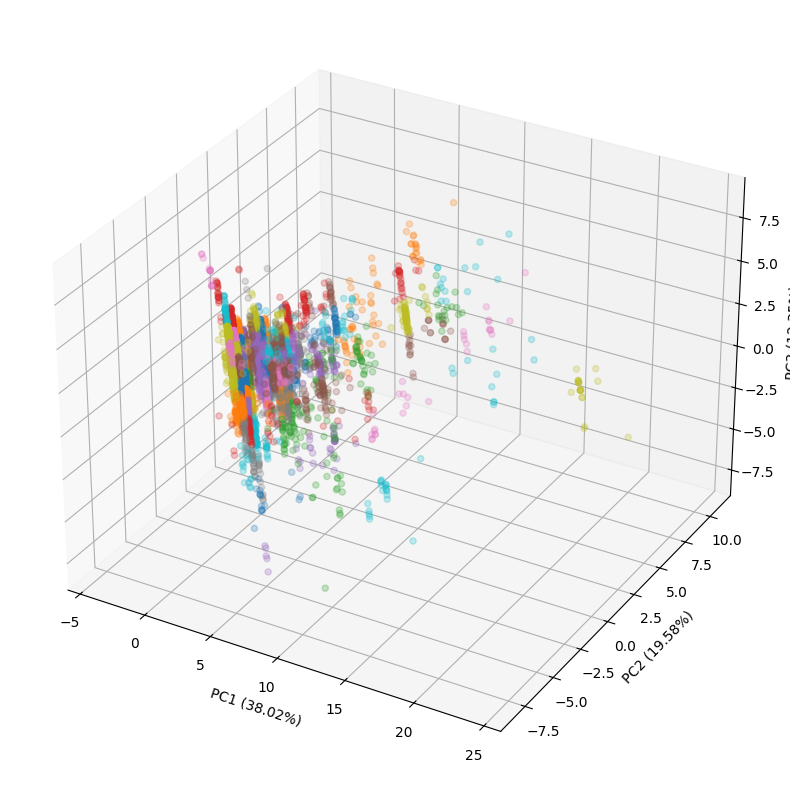

In [14]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=97, random_state=42)

kmeans.fit(desc[['PC1', 'PC2', 'PC3']])
desc['Cluster'] = kmeans.labels_

desc.head()

centroids = kmeans.cluster_centers_

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
for i in range(num_clusters):
    ax.scatter(desc['PC1'][desc['Cluster'] == i], desc['PC2'][desc['Cluster'] == i], desc['PC3'][desc['Cluster'] == i], marker='o', alpha=0.25, label=f'Cluster {i}')
ax.set_xlabel(f'PC1 ({round(pca.explained_variance_ratio_[0]*100, 2)}%)')
ax.set_ylabel(f'PC2 ({round(pca.explained_variance_ratio_[1]*100, 2)}%)')
ax.set_zlabel(f'PC3 ({round(pca.explained_variance_ratio_[2]*100, 2)}%)')
plt.tight_layout()
#plt.legend()
plt.show()

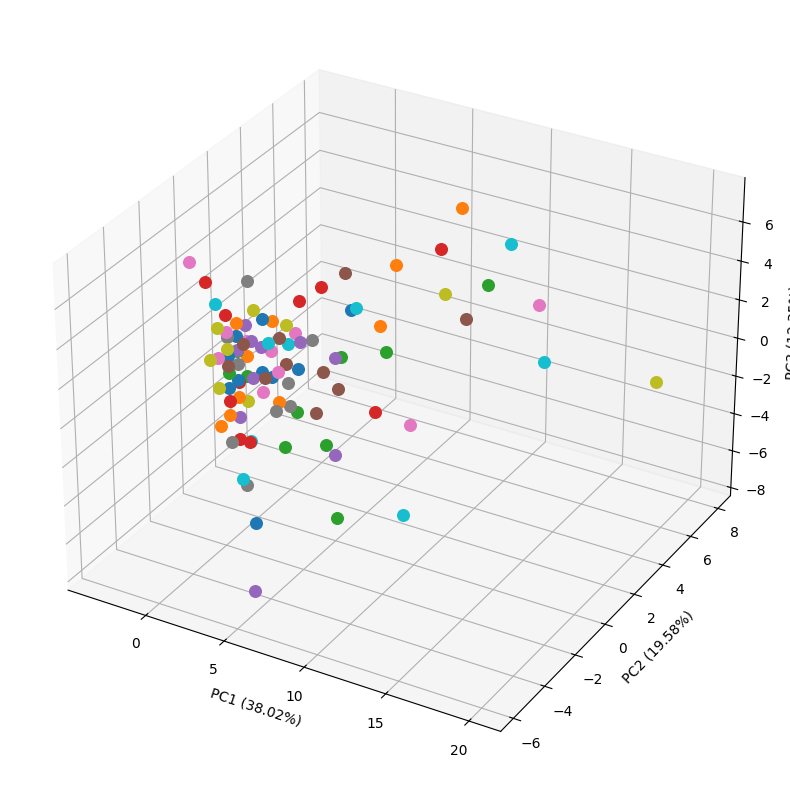

In [15]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
for i in range(num_clusters):
    ax.scatter(centroids[i][0], centroids[i][1], centroids[i][2], marker='o', s=70, label=f'Centroid {i}')
ax.set_xlabel(f'PC1 ({round(pca.explained_variance_ratio_[0]*100, 2)}%)')
ax.set_ylabel(f'PC2 ({round(pca.explained_variance_ratio_[1]*100, 2)}%)')
ax.set_zlabel(f'PC3 ({round(pca.explained_variance_ratio_[2]*100, 2)}%)')
plt.tight_layout()
#plt.legend()
plt.show()

In [16]:
#take the three first PCs for each molecule
principal_components[:,:3]

array([[-1.47343013,  0.17741294, -0.23631484],
       [-2.06346102,  1.3559565 , -1.75960761],
       [ 0.52024278, -0.53853613,  2.06317439],
       ...,
       [ 0.4739641 , -0.51185119,  1.95922949],
       [ 0.47998363, -2.08455028, -0.13265189],
       [-1.46845121, -0.43792532,  2.02387047]])

In [17]:
# get the SMILES of the molecule closest to the center of each cluster
closest_molecules = []

for i in range(num_clusters):
    distances = np.linalg.norm(principal_components[:,:3] - centroids[i], axis=1)
    closest_molecule = data.iloc[np.argmin(distances)]['SMILES']
    closest_molecules.append(closest_molecule)
    print(min(distances))

0.02504613406149896
0.015814257441244747
0.3755010531500637
0.6908608137087133
0.04612540341474277
0.3775190481211973
0.013086356462611892
0.028805058662439514
0.24402937557876167
0.6555852324872847
0.05311306257396152
0.03350284006653249
0.053415670656583064
0.13419825342460048
0.14421910999448076
0.18283761324114212
0.06375050318386447
0.1473498206747441
0.11722607088872418
0.4664685891351664
0.03678392547359607
0.4237126203077355
0.5632629148974091
0.02614106515821357
0.09697984186689472
0.19259910802055652
0.3458578004962676
0.6109875923716436
0.050536907178021416
0.579395156195679
0.043526169552611065
0.6203371100616789
0.1665058633002784
0.5695168177838069
0.07914173575128318
0.13392606398015994
0.07193128396232704
0.031792659055863766
0.0833646449187967
0.40645512837816394
0.22567269072917026
0.1359744467490027
0.4954100387714216
0.07922233491466854
0.5939343001096622
0.40809706916334676
0.022049647802421028
0.26116831607371516
0.032007326259070316
0.16325946837394772
0.11495223

In [18]:
centroids_smiles = closest_molecules

In [19]:
len(closest_molecules)

97

/localhome/rsolazzo/.conda/envs/chemprop/lib/python3.11/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


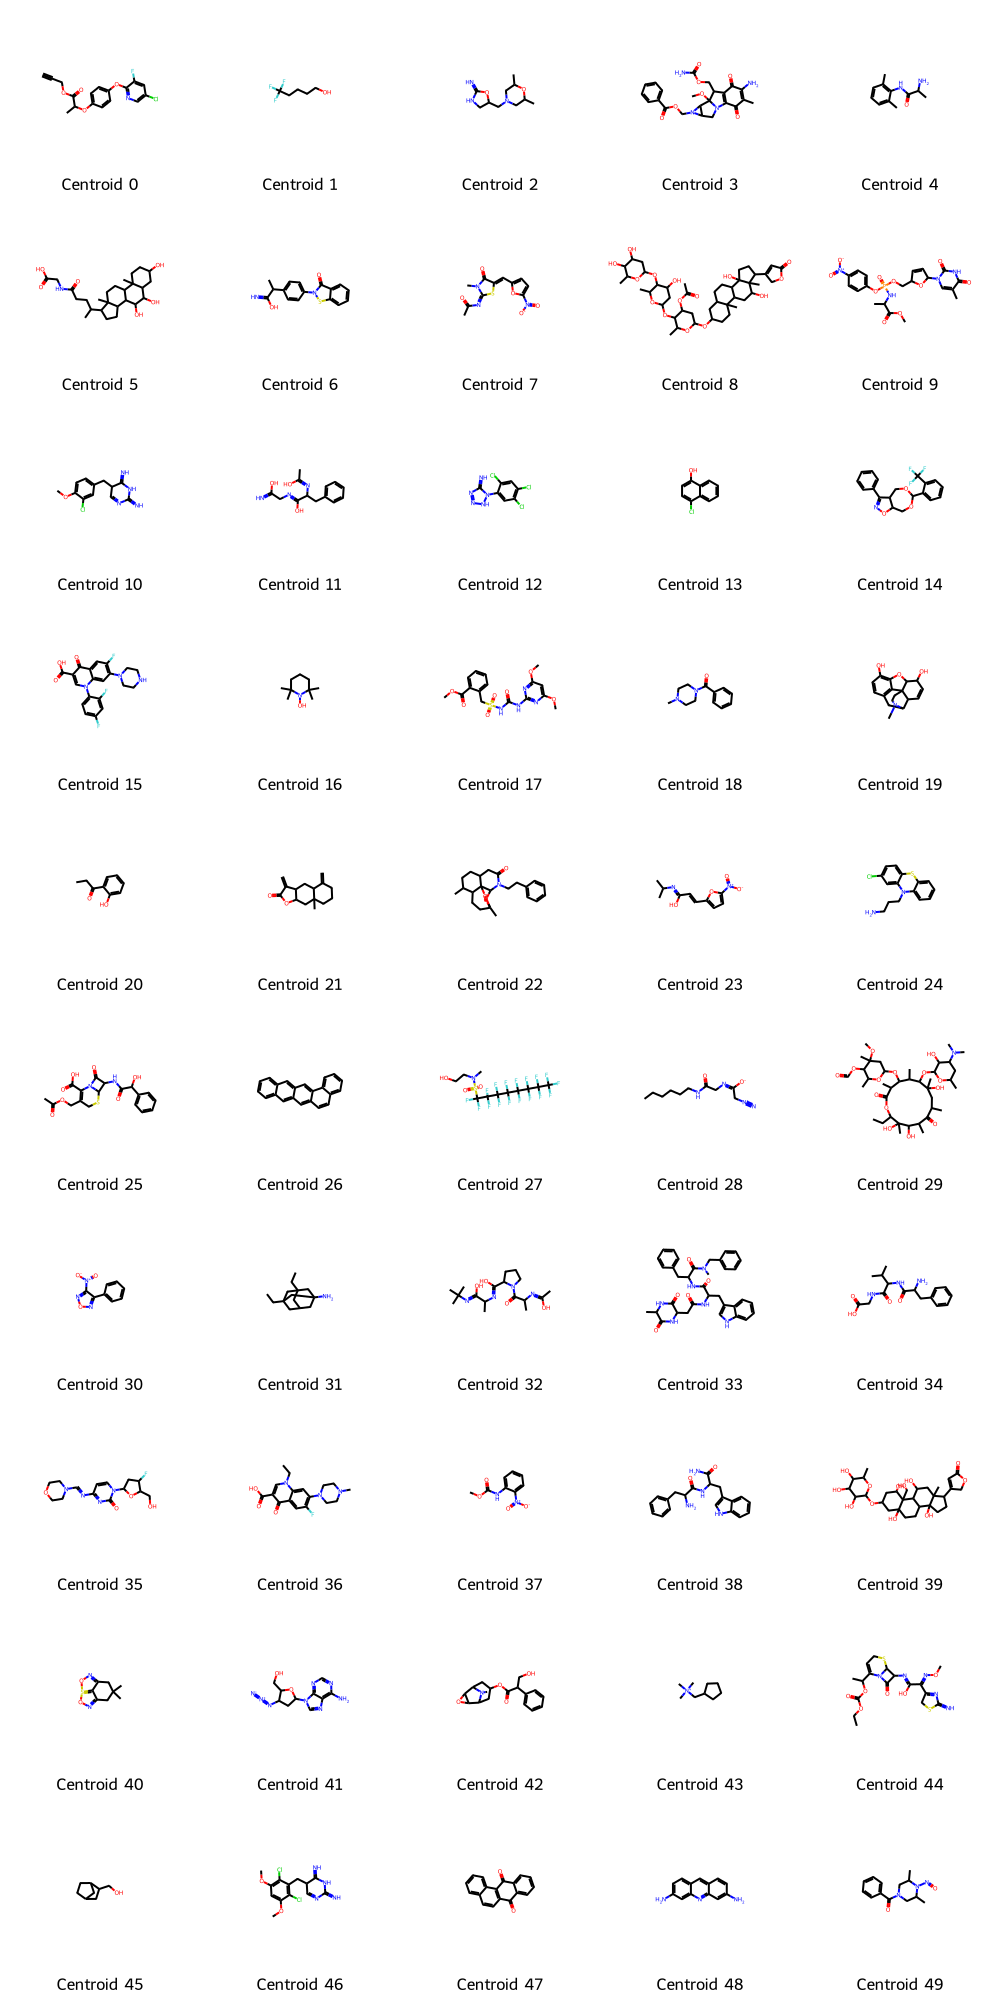

In [20]:
Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in centroids_smiles], molsPerRow=5, subImgSize=(200, 200), legends=[f'Centroid {i}' for i in range(num_clusters)])

## Save the new training.csv

In [21]:
centroids_properties = train[train['SMILES'].isin(centroids_smiles)]
centroids_properties

,SMILES,LogVP,LogP,LogOH,LogBCF,LogHalfLife,BP,Clint,FU,LogHL,LogKmHL,LogKOA,LogKOC,MP,LogMolar
102,Brc1ccc(NC2=NCCN2)cc1,NaN,1.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22743,[N-]=[N+]=NC1CC(n2cnc3c(N)ncnc32)OC1CO,NaN,0.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11783,COC(=O)Nc1ccccc1[N+](=O)[O-],NaN,2.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21853,O=c1nc(N=CN2CCOCC2)ccn1C1CC(F)C(CO)O1,NaN,-0.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2099,CC(=O)OC1CC(OC2CCC3(C)C(CCC4C3CC(O)C3(C)C(C5=C...,NaN,1.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6269,CCCC(CCC)N=NC(=N)N,NaN,1.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3506,CC(C)N(CCC(C(=N)O)c1ccccc1Cl)C(C)C,NaN,2.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2491,CC(C(=N)O)c1ccc(-n2sc3ccccc3c2=O)cc1,NaN,2.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1816,CC(=O)N=C1SC(=Cc2ccc([N+](=O)[O-])o2)C(=O)N1C,NaN,1.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# Subset the train data
out_dir = 'LogP_PCA_data/'
os.makedirs(out_dir, exist_ok=True)

stl_test = test[["SMILES", "LogP"]].dropna()
stl_less_data = centroids_properties[["SMILES", "LogP"]].dropna().sample(frac=1, random_state=42) # Shuffle data
other_properties = train.drop(columns="LogP")

os.makedirs(out_dir + 'STL', exist_ok=True)
stl_less_data.to_csv(out_dir + 'STL/train.csv', index=False)
stl_test.to_csv(out_dir + 'STL/test.csv', index=False)

os.makedirs(out_dir + 'MTL', exist_ok=True)
mtl_less_data = pd.merge(stl_less_data, other_properties, on="SMILES", how="outer")
mtl_less_data.to_csv(out_dir + 'MTL/train.csv', index=False)
test.to_csv(out_dir + 'MTL/test.csv', index=False)

property_list = mtl_less_data.drop(columns='SMILES').columns.to_list()

In [23]:
# train STL
os.system(f'''chemprop train \
--data-path "{out_dir}STL/train.csv" \
--task-type regression \
--epochs 100 \
--output-dir "{out_dir}STL/model/" \
--num-workers 15 ''')

# Predict
os.system(f'''chemprop predict \
--test-path "{out_dir}STL/test.csv" \
--model-path "{out_dir}STL/model/model_0/best.pt" \
--preds-path "{out_dir}STL/preds.csv" \
--num-workers 15''')

# train MTL
os.system(f'''chemprop train \
--data-path "{out_dir}MTL/train.csv" \
--task-type regression \
--epochs 100 \
--target-columns {" ".join(property_list)} \
--task-weights {" ".join([str(10) if p != "LogP" else str(1) for p in property_list])} \
--output-dir "{out_dir}MTL/model/" \
--num-workers 15 ''')

# Predict
os.system(f'''chemprop predict \
--test-path "{out_dir}MTL/test.csv" \
--model-path "{out_dir}MTL/model/model_0/best.pt" \
--preds-path "{out_dir}MTL/preds.csv" \
--num-workers 15''')

Wrote config file to LogP_PCA_data/STL/model/config.toml


/localhome/rsolazzo/.conda/envs/chemprop/lib/python3.11/site-packages/astartes/main.py:325: ImperfectSplittingWarning: Actual train/test split differs from requested size. Requested train size of 0.80, got 0.79. Requested validation size of 0.10, got 0.11. Requested test size of 0.10, got 0.11. 
  warn(
/localhome/rsolazzo/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/rsolazzo/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 T

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 17.03it/s, v_num=1, train_loss=0.737]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 2/2 [00:00<00:00,  5.76it/s, v_num=1, train_loss=1.350, val_loss=0.705]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 2/2 [00:00<00:00,  5.53it/s, v_num=1, train_loss=0.594, val_loss=0.699]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 2/2 [00:00<00:00,  5.14it/s, v_num=1, train_loss=0.477, val_loss=0.679]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 2/2 [00:00<00:00,  5.34it/s, v_num=1, train_loss=0.614, val_loss=0.667]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 2/2 [00:00<00:00,  5.51it/s, v_num=1, train_loss=0.589, val_loss=0.668]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 2/2 [00:00<00:00,  5.23it/s, v_num=1, train_loss=0.419, val_loss=0.653]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7:

`Trainer.fit` stopped: `max_epochs=100` reached.
/localhome/rsolazzo/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/rsolazzo/Digital_chemistry_benchmark/Digital_Chemistry/LogP_PCA_data/STL/model/model_0/checkpoints/best-epoch=85-val_loss=0.27.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/rsolazzo/Digital_chemistry_benchmark/Digital_Chemistry/LogP_PCA_data/STL/model/model_0/checkpoints/best-epoch=85-val_loss=0.27.ckpt


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 281.12it/s]
Entire Test Set results: {'entire_test/mse': 4.3754601789953576}


/localhome/rsolazzo/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/rsolazzo/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/rsolazzo/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/rsolazzo/.conda/envs/chemprop/lib/python3.11/site-pack

Predicting DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 91.95it/s]
Wrote config file to LogP_PCA_data/MTL/model/config.toml


/localhome/rsolazzo/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/rsolazzo/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For mor

Epoch 0: 100%|██████████| 204/204 [00:01<00:00, 118.69it/s, v_num=1, train_loss=0.0947]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 204/204 [00:02<00:00, 97.21it/s, v_num=1, train_loss=0.718, val_loss=0.452] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 204/204 [00:02<00:00, 99.62it/s, v_num=1, train_loss=0.372, val_loss=0.398]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 204/204 [00:02<00:00, 97.33it/s, v_num=1, train_loss=0.559, val_loss=0.501]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 204/204 [00:02<00:00, 95.48it/s, v_num=1, train_loss=0.344, val_loss=0.343]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 204/204 [00:02<00:00, 100.75it/s, v_num=1, train_loss=0.247, val_loss=0.289]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 204/204 [00:02<00:00, 100.44it/s, v_num=1, train_loss=0.289, val_loss=0.288]
Validation: |        

`Trainer.fit` stopped: `max_epochs=100` reached.
/localhome/rsolazzo/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/rsolazzo/Digital_chemistry_benchmark/Digital_Chemistry/LogP_PCA_data/MTL/model/model_0/checkpoints/best-epoch=38-val_loss=0.20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/rsolazzo/Digital_chemistry_benchmark/Digital_Chemistry/LogP_PCA_data/MTL/model/model_0/checkpoints/best-epoch=38-val_loss=0.20.ckpt


Predicting DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 258.30it/s]
Entire Test Set results: {'entire_test/mse': 722.653379451788}


/localhome/rsolazzo/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/rsolazzo/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/rsolazzo/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/rsolazzo/.conda/envs/chemprop/lib/python3.11/site-pack

Predicting DataLoader 0: 100%|██████████| 109/109 [00:00<00:00, 114.69it/s]


0

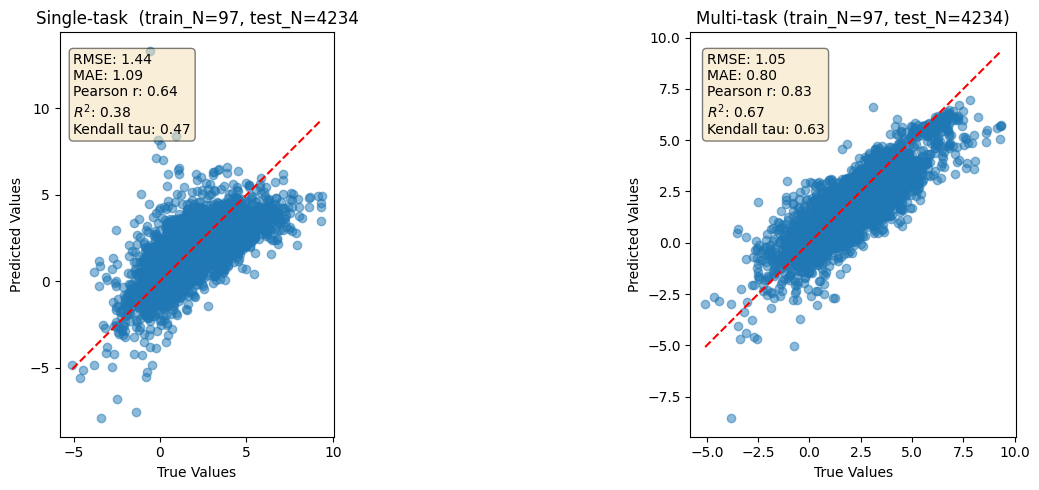

In [24]:
# Plotting results on OPERA test data

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs = axs.flatten()

# Prepare data for single-task
single_task_df = pd.read_csv(out_dir + 'STL/preds_0.csv')
valid_single = single_task_df[['SMILES', "LogP", 'pred_0']].dropna()
true_single_values = valid_single["LogP"]
pred_single_values = valid_single['pred_0']

# Prepare data for multi-task
multi_task_df = pd.read_csv(out_dir + 'MTL/preds_0.csv')
valid_multi = multi_task_df[['SMILES', "LogP", 'pred_0']].dropna()
true_multi_values = valid_multi["LogP"]
pred_multi_values = valid_multi['pred_0']

# Plotting single-task
plot_scatter_and_line(axs[0], true_single_values, pred_single_values, f'Single-task  (train_N={len(stl_less_data)}, test_N={len(valid_single)}')

# Plotting multi-task
plot_scatter_and_line(axs[1], true_multi_values, pred_multi_values, f'Multi-task (train_N={len(mtl_less_data["LogP"].dropna())}, test_N={len(valid_multi)})')

plt.tight_layout()
plt.show()

In [25]:
len(stl_less_data)

97

## SAMPL6 prediction

In [33]:
sampl = pd.read_csv('logP_experimental_values.csv')
sampl = sampl.rename(columns={'Isomeric SMILES': 'SMILES'})

In [34]:
smiles = sampl['SMILES']

new_df = pd.DataFrame(smiles)

columns_to_add = ['LogVP', 'LogP', 'LogOH', 'LogBCF', 'LogHalfLife', 'BP', 'Clint', 'FU', 'LogHL', 'LogKmHL', 'LogKOA', 'LogKOC', 'MP', 'LogMolar']

for column in columns_to_add:
    new_df[column] = np.nan

new_df

,SMILES,LogVP,LogP,LogOH,LogBCF,LogHalfLife,BP,Clint,FU,LogHL,LogKmHL,LogKOA,LogKOC,MP,LogMolar
0,c1ccc2c(c1)c(ncn2)Nc3cccc(c3)C(F)(F)F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,c1ccc2c(c1)c(ncn2)NCc3ccc(cc3)Cl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,c1ccc(cc1)CNc2c3ccccc3ncn2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Cc1ccc2c(c1)c(c(c(=O)[nH]2)CC(=O)O)c3ccccc3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,COc1cccc(c1)Nc2c3ccccc3ncn2.Cl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,c1ccc(cc1)n2c3c(cn2)c(ncn3)N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,c1ccc2c(c1)c(ncn2)Nc3cccc(c3)Cl.Cl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Cc1cccc(c1)Nc2c3cc(c(cc3ncn2)OC)OC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,c1ccc(cc1)n2cnc3c2ccc(c3)N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,c1ccc2c(c1)ncn2c3ccc(cc3)O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
new_df['LogP'] = sampl['logP mean']

new_df

,SMILES,LogVP,LogP,LogOH,LogBCF,LogHalfLife,BP,Clint,FU,LogHL,LogKmHL,LogKOA,LogKOC,MP,LogMolar
0,c1ccc2c(c1)c(ncn2)Nc3cccc(c3)C(F)(F)F,NaN,4.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,c1ccc2c(c1)c(ncn2)NCc3ccc(cc3)Cl,NaN,3.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,c1ccc(cc1)CNc2c3ccccc3ncn2,NaN,3.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Cc1ccc2c(c1)c(c(c(=O)[nH]2)CC(=O)O)c3ccccc3,NaN,3.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,COc1cccc(c1)Nc2c3ccccc3ncn2.Cl,NaN,3.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,c1ccc(cc1)n2c3c(cn2)c(ncn3)N,NaN,2.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,c1ccc2c(c1)c(ncn2)Nc3cccc(c3)Cl.Cl,NaN,3.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Cc1cccc(c1)Nc2c3cc(c(cc3ncn2)OC)OC,NaN,2.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,c1ccc(cc1)n2cnc3c2ccc(c3)N,NaN,1.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,c1ccc2c(c1)ncn2c3ccc(cc3)O,NaN,3.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
new_df.to_csv('sampl_logP.csv', index=False)

In [37]:
# Predict using STL model
os.system(f'''chemprop predict \
--test-path "sampl_logP.csv" \
--model-path "{out_dir}STL/model/model_0/best.pt" \
--preds-path "SAMPL_STL_preds.csv" \
--num-workers 15''')

# Predict using MTL model
os.system(f'''chemprop predict \
--test-path "sampl_logP.csv" \
--model-path "{out_dir}MTL/model/model_0/best.pt" \
--preds-path "SAMPL_MTL_preds.csv" \
--num-workers 15''')

/localhome/rsolazzo/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/rsolazzo/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For mor

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


/localhome/rsolazzo/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/rsolazzo/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For mor

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


0

In [38]:
results_mtl = pd.read_csv('SAMPL_MTL_preds_0.csv')
results_stl = pd.read_csv('SAMPL_STL_preds_0.csv')

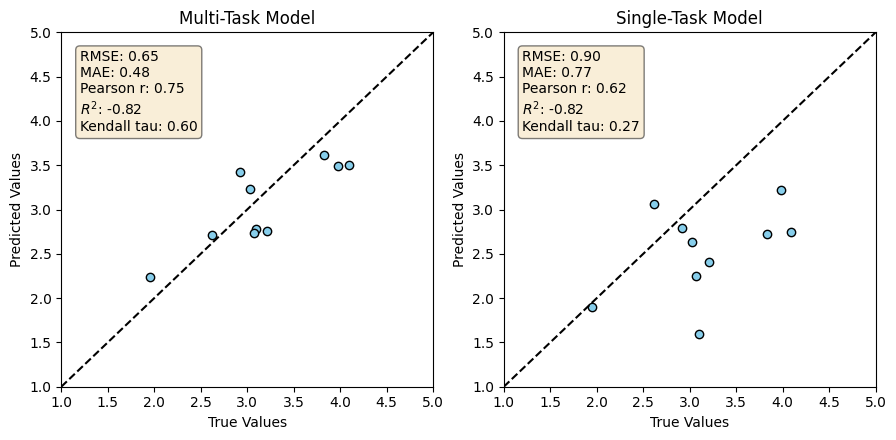

In [42]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr, kendalltau

# Create a figure and two subplots
fig, axs = plt.subplots(1, 2, figsize=(9, 4.5))

# Set axis limits
xlim = ylim = (1, 5)

# First scatter plot
axs[0].scatter(results_mtl['LogP'], results_mtl['pred_0'], edgecolor='black', color='skyblue')
# Set limits for the plot
axs[0].set_xlim(xlim)
axs[0].set_ylim(ylim)
# Add diagonal line
axs[0].plot(xlim, ylim, 'k--')
# Calculate statistics
rmse = np.sqrt(mean_squared_error(results_mtl['LogP'], results_mtl['pred_0']))
mae = mean_absolute_error(results_mtl['LogP'], results_mtl['pred_0'])
r, _ = pearsonr(results_mtl['LogP'], results_mtl['pred_0'])
#r2 = r2_score(results_mtl['LogP'], results_mtl['pred_0'])
tau, _ = kendalltau(results_mtl['LogP'], results_mtl['pred_0'])
textstr = f'RMSE: {rmse:.2f}\nMAE: {mae:.2f}\nPearson r: {r:.2f}\n$R^2$: {r2:.2f}\nKendall tau: {tau:.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
axs[0].text(0.05, 0.95, textstr, transform=axs[0].transAxes, fontsize=10, verticalalignment='top', bbox=props)

axs[0].set_xlabel('True Values')
axs[0].set_ylabel('Predicted Values')
axs[0].set_title('Multi-Task Model')

# Second scatter plot
axs[1].scatter(results_stl['LogP'], results_stl['pred_0'], edgecolor='black', color='skyblue')
# Set limits for the plot
axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)
# Add diagonal line
axs[1].plot(xlim, ylim, 'k--')
# Calculate statistics
rmse = np.sqrt(mean_squared_error(results_stl['LogP'], results_stl['pred_0']))
mae = mean_absolute_error(results_stl['LogP'], results_stl['pred_0'])
r, _ = pearsonr(results_stl['LogP'], results_stl['pred_0'])
#r2 = r2_score(results_stl['LogP'], results_stl['pred_0'])
tau, _ = kendalltau(results_stl['LogP'], results_stl['pred_0'])
textstr = f'RMSE: {rmse:.2f}\nMAE: {mae:.2f}\nPearson r: {r:.2f}\n$R^2$: {r2:.2f}\nKendall tau: {tau:.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
axs[1].text(0.05, 0.95, textstr, transform=axs[1].transAxes, fontsize=10, verticalalignment='top', bbox=props)

axs[1].set_xlabel('True Values')
axs[1].set_ylabel('Predicted Values')
axs[1].set_title('Single-Task Model')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, t
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define the dataset sizes and output directory
sizes = [0.005,0.05, 0.1, 0.25, 0.5, 0.75, 1]
out_dir = 'LogP_different_sizes/'

# Function to calculate 90% confidence interval
def confidence_interval(data, confidence=0.90):
    n = len(data)
    mean = np.mean(data)
    sem = np.std(data, ddof=1) / np.sqrt(n)
    margin_of_error = sem * t.ppf((1 + confidence) / 2., n-1)
    return mean, mean - margin_of_error, mean + margin_of_error

# Initialize dictionary to store results
metrics = ["pearson", "mae", "rmse", "r2"]
results = {metric: {s: {"single_task": [], "multi_task": []} for s in sizes} for metric in metrics}

# Collect metrics for each dataset size and each seed
for seed in range(3):
    for s in sizes:
        # Prepare data for single-task
        single_task_df = pd.read_csv(out_dir + f'seed_{seed}/{s}_STL/preds_0.csv')
        valid_single = single_task_df[['SMILES', "LogP", 'pred_0']].dropna()
        true_single_values = valid_single["LogP"]
        pred_single_values = valid_single['pred_0']

        # Prepare data for multi-task
        multi_task_df = pd.read_csv(out_dir + f'seed_{seed}/{s}_MTL/preds_0.csv')
        valid_multi = multi_task_df[['SMILES', "LogP", 'pred_0']].dropna()
        true_multi_values = valid_multi["LogP"]
        pred_multi_values = valid_multi['pred_0']

        # Calculate metrics and store results
        results["pearson"][s]["single_task"].append(pearsonr(true_single_values, pred_single_values)[0])
        results["mae"][s]["single_task"].append(mean_absolute_error(true_single_values, pred_single_values))
        results["rmse"][s]["single_task"].append(mean_squared_error(true_single_values, pred_single_values, squared=False))
        results["r2"][s]["single_task"].append(r2_score(true_single_values, pred_single_values))

        results["pearson"][s]["multi_task"].append(pearsonr(true_multi_values, pred_multi_values)[0])
        results["mae"][s]["multi_task"].append(mean_absolute_error(true_multi_values, pred_multi_values))
        results["rmse"][s]["multi_task"].append(mean_squared_error(true_multi_values, pred_multi_values, squared=False))
        results["r2"][s]["multi_task"].append(r2_score(true_multi_values, pred_multi_values))

# Calculate mean and confidence intervals for each metric
aggregated_results = {metric: [] for metric in metrics}

for metric in metrics:
    for s in sizes:
        single_mean, single_lower, single_upper = confidence_interval(results[metric][s]["single_task"])
        multi_mean, multi_lower, multi_upper = confidence_interval(results[metric][s]["multi_task"])
        aggregated_results[metric].append([s, single_mean, single_lower, single_upper, multi_mean, multi_lower, multi_upper])

# Convert results to DataFrames
dfs = {metric: pd.DataFrame(aggregated_results[metric], columns=["Size", "Single-task mean", "Single-task lower CI", "Single-task upper CI",
                                                                 "Multi-task mean", "Multi-task lower CI", "Multi-task upper CI"]) for metric in metrics}

# Plotting the results




/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarnin

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, t
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define the dataset sizes and output directory
sizes = [0.005,0.01,0.02, 0.03, 0.04,0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
out_dir = 'LogP_different_sizes/'

# Function to calculate 90% confidence interval
def confidence_interval(data, confidence=0.90):
    n = len(data)
    mean = np.mean(data)
    sem = np.std(data, ddof=1) / np.sqrt(n)
    margin_of_error = sem * t.ppf((1 + confidence) / 2., n-1)
    return mean, mean - margin_of_error, mean + margin_of_error

# Initialize dictionary to store results
metrics = ["pearson", "mae", "rmse", "r2"]
results = {metric: {s: {"single_task": [], "multi_task": []} for s in sizes} for metric in metrics}

# Collect metrics for each dataset size and each seed
for seed in range(3):
    for s in sizes:
        # Prepare data for single-task
        single_task_df = pd.read_csv(out_dir + f'seed_{seed}/{s}_STL/preds_0.csv')
        valid_single = single_task_df[['SMILES', "LogP", 'pred_0']].dropna()
        true_single_values = valid_single["LogP"]
        pred_single_values = valid_single['pred_0']

        # Prepare data for multi-task
        multi_task_df = pd.read_csv(out_dir + f'seed_{seed}/{s}_MTL/preds_0.csv')
        valid_multi = multi_task_df[['SMILES', "LogP", 'pred_0']].dropna()
        true_multi_values = valid_multi["LogP"]
        pred_multi_values = valid_multi['pred_0']

        # Calculate metrics and store results
        results["pearson"][s]["single_task"].append(pearsonr(true_single_values, pred_single_values)[0])
        results["mae"][s]["single_task"].append(mean_absolute_error(true_single_values, pred_single_values))
        results["rmse"][s]["single_task"].append(mean_squared_error(true_single_values, pred_single_values, squared=False))
        results["r2"][s]["single_task"].append(r2_score(true_single_values, pred_single_values))

        results["pearson"][s]["multi_task"].append(pearsonr(true_multi_values, pred_multi_values)[0])
        results["mae"][s]["multi_task"].append(mean_absolute_error(true_multi_values, pred_multi_values))
        results["rmse"][s]["multi_task"].append(mean_squared_error(true_multi_values, pred_multi_values, squared=False))
        results["r2"][s]["multi_task"].append(r2_score(true_multi_values, pred_multi_values))

# Calculate mean and confidence intervals for each metric
aggregated_results = {metric: [] for metric in metrics}

for metric in metrics:
    for s in sizes:
        single_mean, single_lower, single_upper = confidence_interval(results[metric][s]["single_task"])
        multi_mean, multi_lower, multi_upper = confidence_interval(results[metric][s]["multi_task"])
        aggregated_results[metric].append([s, single_mean, single_lower, single_upper, multi_mean, multi_lower, multi_upper])

# Convert results to DataFrames
dfs_zoom = {metric: pd.DataFrame(aggregated_results[metric], columns=["Size", "Single-task mean", "Single-task lower CI", "Single-task upper CI",
                                                                 "Multi-task mean", "Multi-task lower CI", "Multi-task upper CI"]) for metric in metrics}

# Plotting the results




/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarnin

In [19]:
# Split the train/test data
from modules.utils_data import load_data
from sklearn.model_selection import train_test_split

df_combined = load_data()
train, test = train_test_split(df_combined, test_size=0.3, random_state=42)
for col in df_combined.columns[1:]:
    print(f'{col}: {test[col].count()/df_combined[col].count()}')
stl_test = test[["SMILES", "LogP"]].dropna()
stl_data = train[["SMILES", "LogP"]].dropna()

Loading data from file
File not found, reading from SDF files
Reading OPERA_Data/VP_QR.sdf


100%|██████████| 2819/2819 [00:00<00:00, 7799.94it/s]


Reading OPERA_Data/LogP_QR.sdf


  0%|          | 0/13963 [00:00<?, ?it/s][16:53:45] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 12 22 23 24 25 26 27
[16:53:45] ERROR: Could not sanitize molecule ending on line 38202
[16:53:45] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 12 22 23 24 25 26 27
100%|██████████| 13963/13963 [00:02<00:00, 5986.30it/s]


Reading OPERA_Data/AOH_QR.sdf


100%|██████████| 692/692 [00:00<00:00, 10781.59it/s]


Reading OPERA_Data/BCF_QR.sdf


  0%|          | 0/626 [00:00<?, ?it/s][16:53:47] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 12 22 23 24 25 26 27
[16:53:47] ERROR: Could not sanitize molecule ending on line 5019
[16:53:47] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 12 22 23 24 25 26 27
100%|██████████| 626/626 [00:00<00:00, 6949.93it/s]


Reading OPERA_Data/Biodeg_QR.sdf


100%|██████████| 150/150 [00:00<00:00, 7002.64it/s]


Reading OPERA_Data/BP_QR.sdf


100%|██████████| 5434/5434 [00:00<00:00, 9341.35it/s]


Reading OPERA_Data/Clint_QR.sdf


100%|██████████| 551/551 [00:00<00:00, 5360.38it/s]


Reading OPERA_Data/FU_QR.sdf


100%|██████████| 1613/1613 [00:00<00:00, 4552.69it/s]


Reading OPERA_Data/HL_QR.sdf


100%|██████████| 697/697 [00:00<00:00, 7951.25it/s]


Reading OPERA_Data/KM_QR.sdf


100%|██████████| 541/541 [00:00<00:00, 6549.85it/s]


Reading OPERA_Data/KOA_QR.sdf


100%|██████████| 270/270 [00:00<00:00, 7760.52it/s]


Reading OPERA_Data/KOC_QR.sdf


100%|██████████| 728/728 [00:00<00:00, 6624.99it/s]


Reading OPERA_Data/MP_QR.sdf


  8%|▊         | 688/8698 [00:00<00:01, 6879.37it/s][16:53:49] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 12 22 23 24 25 26 27
[16:53:49] ERROR: Could not sanitize molecule ending on line 52970
[16:53:49] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 12 22 23 24 25 26 27
100%|██████████| 8698/8698 [00:01<00:00, 6878.02it/s]


Reading OPERA_Data/WS_QR.sdf


100%|██████████| 5269/5269 [00:00<00:00, 6716.01it/s]


LogVP: 0.3108348134991119
LogP: 0.303577830357783
LogOH: 0.3352601156069364
LogBCF: 0.27884615384615385
LogHalfLife: 0.37333333333333335
BP: 0.3094054849990797
Clint: 0.2783882783882784
FU: 0.29283489096573206
LogHL: 0.3199426111908178
LogKmHL: 0.28835489833641403
LogKOA: 0.32222222222222224
LogKOC: 0.32088520055325037
MP: 0.30270770654940987
LogMolar: 0.29888803680981596


/tmp/ipykernel_1577071/677350783.py:19: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axs[0].errorbar(
/tmp/ipykernel_1577071/677350783.py:39: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  axs[0].errorbar(
/tmp/ipykernel_1577071/677350783.py:55: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axs[1].errorbar(
/tmp/ipykernel_1577071/677350783.py:75: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  axs[1].errorbar(


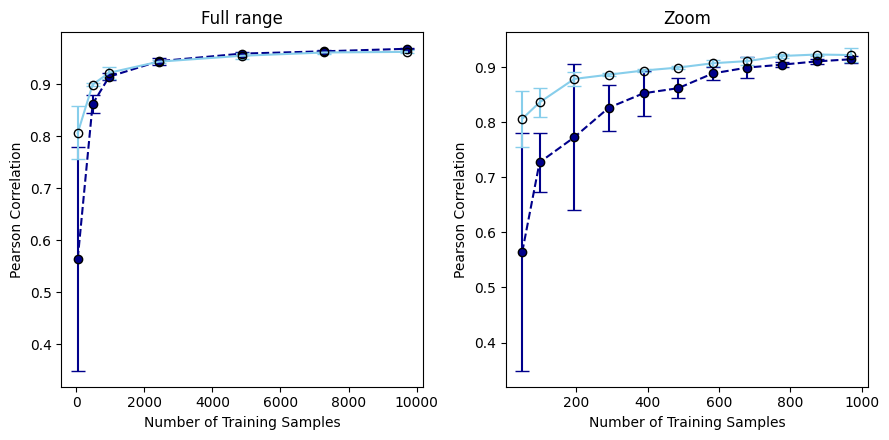

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr, kendalltau
pearson_df = dfs["pearson"]
pearson_df_zoom = dfs_zoom["pearson"]
# Create a figure and two subplots
fig, axs = plt.subplots(1, 2, figsize=(9, 4.5))

# Set axis limits
xlim = ylim = (1, 5)

# First scatter plot

# Set limits for the plot
# axs[0].set_xlim(xlim)
# axs[0].set_ylim(ylim)
# # Add diagonal line
axs[0].errorbar(
    pearson_df["Size"] * len(stl_data),
    pearson_df["Single-task mean"],
    yerr=[
        pearson_df["Single-task mean"] - pearson_df["Single-task lower CI"],
        pearson_df["Single-task upper CI"] - pearson_df["Single-task mean"]
    ],
    label="Single-task model",
    fmt='o',  # circle marker
    capsize=5,  # size of the caps on error bars
    linestyle='--',  # dashed line
    color='darkblue',  # change color to reds
    marker='o',
    #change color of edge
    markeredgecolor = 'black'


)

# Plotting Multi-task model
axs[0].errorbar(
    pearson_df["Size"] * len(stl_data),
    pearson_df["Multi-task mean"],
    yerr=[
        pearson_df["Multi-task mean"] - pearson_df["Multi-task lower CI"],
        pearson_df["Multi-task upper CI"] - pearson_df["Multi-task mean"]
    ],
    label="Multi-task model",
    fmt='s',  # square marker
    capsize=5,  # size of the caps on error bars
    linestyle='-',  # solid line
    fillstyle='none',  # no fill for the marker\
    color='skyblue' , # change color to reds
    marker='o',
    markeredgecolor='black'
)
axs[1].errorbar(
    pearson_df_zoom["Size"] * len(stl_data),
    pearson_df_zoom["Single-task mean"],
    yerr=[
        pearson_df_zoom["Single-task mean"] - pearson_df_zoom["Single-task lower CI"],
        pearson_df_zoom["Single-task upper CI"] - pearson_df_zoom["Single-task mean"]
    ],
    label="Single-task model",
    fmt='o',  # circle marker
    capsize=5,  # size of the caps on error bars
    linestyle='--',  # dashed line
    color='darkblue',  # change color to reds
    marker='o',
    #change color of edge
    markeredgecolor = 'black'


)

# Plotting Multi-task model
axs[1].errorbar(
    pearson_df_zoom["Size"] * len(stl_data),
    pearson_df_zoom["Multi-task mean"],
    yerr=[
        pearson_df_zoom["Multi-task mean"] - pearson_df_zoom["Multi-task lower CI"],
        pearson_df_zoom["Multi-task upper CI"] - pearson_df_zoom["Multi-task mean"]
    ],
    label="Multi-task model",
    fmt='s',  # square marker
    capsize=5,  # size of the caps on error bars
    linestyle='-',  # solid line
    fillstyle='none',  # no fill for the marker\
    color='skyblue' , # change color to reds
    marker='o',
    markeredgecolor='black'
)


axs[0].set_xlabel("Number of Training Samples")
axs[0].set_ylabel('Pearson Correlation')
axs[0].set_title('Full range')

# Second scatter plot
# Set limits for the plot
# axs[1].set_xlim(xlim)
# axs[1].set_ylim(ylim)

axs[1].set_xlabel("Number of Training Samples")
axs[1].set_ylabel('Pearson Correlation')
axs[1].set_title('Zoom')

# Adjust layout and show the plots
plt.tight_layout()
plt.savefig('pearson_correlation.png', dpi=1000)


In [27]:
pearson_df_zoom

,Size,Single-task mean,Single-task lower CI,Single-task upper CI,Multi-task mean,Multi-task lower CI,Multi-task upper CI
0,0.005,0.564478,0.349081,0.779875,0.806222,0.755239,0.857205
1,0.010,0.727148,0.672915,0.781381,0.836054,0.809509,0.862599
2,0.020,0.772667,0.640144,0.905189,0.878661,0.865698,0.891624
3,0.030,0.826477,0.784568,0.868385,0.886411,0.883672,0.889150
4,0.040,0.852600,0.811731,0.893470,0.893903,0.891557,0.896250
5,0.050,0.861886,0.843706,0.880067,0.899290,0.897143,0.901437
6,0.060,0.888645,0.876145,0.901144,0.907119,0.901824,0.912414
7,0.070,0.899353,0.880192,0.918514,0.911070,0.904405,0.917736
8,0.080,0.904599,0.899626,0.909572,0.920351,0.917440,0.923262
9,0.090,0.910523,0.906655,0.914391,0.922972,0.921147,0.924797


In [21]:
len(stl_data)

9713

In [22]:
#print rdkit version
import rdkit
print(rdkit.__version__)

2023.09.6
